# Navigation

---

In this notebook, you will find my implementation detail of a deep double Q-network to solve the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

Next, we will start the environment! Since my operating system is 64-bit Windows 7, I have to change the `file_name` parameter to match the location of the Unity environment that I download.

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Design a Deep Double Q-network to Solve the Environment

The deep double Q-network is implemented in two python scripts: dqn_agent_double.py and model.py

In dqn_agent_double.py, we build two classes: Agent and ReplayBuffer. Agent defines interaction with and learning from the environment. ReplayBuffer is essentially a fixed-size buffer to store experience tuples. 

In model.py, we set up a neural network architecture to approximate state-action mapping that represents the optimal action-value function. 

In [5]:
from dqn_agent_double import Agent

agent = Agent(state_size=37, action_size=4, seed=0)

In [6]:
def dqn_double(n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Double Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    scores_window_mean = []            # list containing average scores from last 100 episodes  
    eps = eps_start                    # initialize epsilon
    solved_counter = 0                 # count at what episode the environment is solved
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0 
        while True:
            action = agent.act(state, eps)            
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)            
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step                       
                       
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        scores_window_mean.append(np.mean(scores_window)) # save average score from last 100 episodes
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if i_episode % 500 == 0:
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_doubleQ-%d.pth' % i_episode) 
        if np.mean(scores_window)>=15.0:
            solved_counter += 1
            if solved_counter==1:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
                torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_doubleQ_SOLVED-%d.pth' % i_episode)
#           break       
    return scores, scores_window_mean 

scores, score_window_mean = dqn_double()

# Save scores in a pickle file
zipScore = [scores, score_window_mean]
with open('zipScore.pickle', 'wb') as f_zipScore:
     pickle.dump(zipScore, f_zipScore, pickle.HIGHEST_PROTOCOL)

Episode 100	Average Score: 1.10
Episode 200	Average Score: 4.46
Episode 300	Average Score: 8.44
Episode 400	Average Score: 10.69
Episode 500	Average Score: 13.14
Episode 600	Average Score: 14.75
Episode 689	Average Score: 15.02
Environment solved in 589 episodes!	Average Score: 15.02
Episode 700	Average Score: 14.94
Episode 800	Average Score: 15.26
Episode 900	Average Score: 15.40
Episode 1000	Average Score: 16.06
Episode 1100	Average Score: 16.35
Episode 1200	Average Score: 16.33
Episode 1300	Average Score: 15.49
Episode 1400	Average Score: 15.81
Episode 1500	Average Score: 16.67
Episode 1600	Average Score: 17.10
Episode 1700	Average Score: 16.15
Episode 1800	Average Score: 15.42
Episode 1900	Average Score: 15.11
Episode 2000	Average Score: 15.28


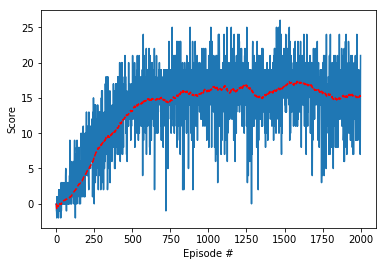

In [7]:
# Load scores from a pickle file
with open('zipScore.pickle', 'rb') as f_zipScore:
     [scores, score_window_mean] = pickle.load(f_zipScore)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(scores)), score_window_mean,'r--')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Trained AI Agent to Play the Game!

In [9]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_doubleQ_SOLVED-689.pth'))
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)        # select an action     
    env_info = env.step(action)[brain_name]        # send the action to the environment 
    
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 18.0


In [10]:
env.close()